In [78]:
from osgeo import gdal
import rasterio
import numpy as np
import rasterio.features
from shapely.geometry import shape, mapping
import geojson
from rasterio.transform import from_origin

In [14]:
def dem_to_raster(dem_path, threshold, output_path):
    # Read the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        nodata = src.nodata

    # Create a mask for valid data (not NoData)
    valid_data_mask = (dem != nodata)

    # Calculate the gradient
    gradient_x, gradient_y = np.gradient(dem, profile['transform'][0], profile['transform'][4])

    # Calculate the slope in degrees
    slope = np.degrees(np.arctan(np.sqrt(gradient_x**2 + gradient_y**2)))

    # Apply the slope threshold and the valid data mask
    mask = (slope >= threshold) & valid_data_mask

    # Update the profile to reflect the number of layers and dtype
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw',
        nodata=0  # Set the NoData value to 0 for uint8
    )

    # Write the mask to a new raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask.astype(rasterio.uint8), 1)


In [ ]:
dem_to_raster('Raw_Spatial_Data/dem_laos.tif', 40, 'Inputs_Glaes/data/Laos_slope_excluded.tif')

# Using a conditional DEM, resolution 3s

In [58]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import sobel, gaussian_filter

def dem_to_raster_three(dem_path, threshold, output_path, sigma=1):
    # Read the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        nodata = src.nodata

        # Extract latitude from transform (assuming it's a regular grid, so we use the top-left corner)
        latitude = transform[5]

    # Calculate the approximate pixel size in meters for 3 arc-seconds
    pixel_size_m = 90  # Approximate at the equator (in meters)
    latitude_correction = np.cos(np.radians(latitude))  # Correct for latitude
    pixel_size_x = pixel_size_m * latitude_correction
    pixel_size_y = pixel_size_m * latitude_correction

    # Create a mask for valid data (not NoData)
    if nodata is not None:
        valid_data_mask = dem != nodata
    else:
        valid_data_mask = np.ones_like(dem, dtype=bool)  # Assume all data is valid if no nodata is set

    # Smooth the DEM using a Gaussian filter
    smoothed_dem = gaussian_filter(dem, sigma=sigma)

    # Calculate gradients using Sobel operators, incorporating pixel size
    gradient_x = sobel(smoothed_dem, axis=1) / (2 * pixel_size_x)  # X gradient (easting), adjusted for pixel size
    gradient_y = sobel(smoothed_dem, axis=0) / (2 * pixel_size_y)  # Y gradient (northing), adjusted for pixel size

    # Calculate the slope in degrees
    slope = np.degrees(np.arctan(np.sqrt(gradient_x**2 + gradient_y**2)))

    # Debugging: Print slope statistics
    print(f"Slope min: {np.min(slope)}, max: {np.max(slope)}, mean: {np.mean(slope)}")

    # Apply the slope threshold and the valid data mask
    mask = (slope >= threshold) & valid_data_mask
    
    # Calculate the percentage of points with value 1
    total_points = np.sum(valid_data_mask)
    selected_points = np.sum(mask)
    percentage_selected = (selected_points / total_points) * 100 if total_points > 0 else 0

    # Print the percentage of selected points
    print(f"Percentage of points with slope >= {threshold} degrees: {percentage_selected:.2f}%")

    # Debugging: Print mask statistics
    print(f"Threshold: {threshold}, Mask sum: {selected_points}, Mask mean: {np.mean(mask)}")

    # Update the profile to reflect the number of layers, dtype, and nodata value
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='deflate',
        nodata=0  # Set the NoData value to 0 for uint8
    )

    # Write the mask to a new raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask.astype(rasterio.uint8), 1)

    print(f"Output raster saved to {output_path}")

In [125]:
dem_to_raster_three('Raw_Spatial_Data/dem_laos.tif', 8.53, 'Inputs_Glaes/data/Laos_slope_excluded_wind.tif', 2) # Sigma is the smoothing factor

Slope min: 0.0, max: 89.7841513083397, mean: 9.798512695280236
Percentage of points with slope >= 8.53 degrees: 78.02%
Threshold: 8.53, Mask sum: 21952293, Mask mean: 0.23580875512105393
Output raster saved to Inputs_Glaes/data/Laos_slope_excluded_wind.tif


# FOR PV: Using conditioned DEM, resolution 3s 

In [73]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import sobel, gaussian_filter

def dem_to_raster_pv_exclusion(dem_path, north_east_west_threshold, south_threshold, output_path, sigma=1):
    # Read the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        nodata = src.nodata

        # Extract latitude from transform (assuming it's a regular grid, so we use the top-left corner)
        latitude = transform[5]

    # Calculate the approximate pixel size in meters for 3 arc-seconds
    pixel_size_m = 90  # Approximate at the equator (in meters)
    latitude_correction = np.cos(np.radians(latitude))  # Correct for latitude
    pixel_size_x = pixel_size_m * latitude_correction
    pixel_size_y = pixel_size_m * latitude_correction

    # Create a mask for valid data (not NoData)
    if nodata is not None:
        valid_data_mask = dem != nodata
    else:
        valid_data_mask = np.ones_like(dem, dtype=bool)  # Assume all data is valid if no nodata is set

    # Smooth the DEM using a Gaussian filter
    smoothed_dem = gaussian_filter(dem, sigma=sigma)

    # Calculate gradients using Sobel operators, incorporating pixel size
    gradient_x = sobel(smoothed_dem, axis=1) / (2 * pixel_size_x)  # X gradient (easting), adjusted for pixel size
    gradient_y = sobel(smoothed_dem, axis=0) / (2 * pixel_size_y)  # Y gradient (northing), adjusted for pixel size

    # Calculate the slope in degrees
    slope = np.degrees(np.arctan(np.sqrt(gradient_x**2 + gradient_y**2)))

    # Calculate the aspect in degrees
    aspect = np.degrees(np.arctan2(-gradient_y, gradient_x))
    aspect = np.where(aspect < 0, 360 + aspect, aspect)

    # Debugging: Print slope and aspect statistics
    print(f"Slope min: {np.min(slope)}, max: {np.max(slope)}, mean: {np.mean(slope)}")
    print(f"Aspect min: {np.min(aspect)}, max: {np.max(aspect)}, mean: {np.mean(aspect)}")

    # Apply the slope thresholds based on aspect direction and valid data mask
    north_east_west_mask = (aspect >= 45) & (aspect <= 135) | (aspect >= 225) & (aspect <= 315)
    south_mask = (aspect > 135) & (aspect < 225)

    exclusion_mask = (
        ((north_east_west_mask) & (slope >= north_east_west_threshold)) |
        ((south_mask) & (slope >= south_threshold))
    ) & valid_data_mask

    # Calculate the percentage of points excluded
    total_points = np.sum(valid_data_mask)
    selected_points = np.sum(exclusion_mask)
    percentage_selected = (selected_points / total_points) * 100 if total_points > 0 else 0

    # Print the percentage of selected points
    print(f"Percentage of points excluded: {percentage_selected:.2f}%")

    # Debugging: Print exclusion mask statistics
    print(f"Exclusion Mask sum: {selected_points}, Exclusion Mask mean: {np.mean(exclusion_mask)}")

    # Update the profile to reflect the number of layers, dtype, and nodata value
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='deflate',
        nodata=0  # Set the NoData value to 0 for uint8
    )

    # Write the exclusion mask to a new raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(exclusion_mask.astype(rasterio.uint8), 1)

    print(f"Output raster saved to {output_path}")


In [130]:
# dem, nort_east_west_treshold, south treshold
dem_to_raster_pv_exclusion('Raw_Spatial_Data/dem_laos.tif', 6.28, 33, 'Inputs_Glaes/data/Laos_slope_excluded_pv.tif', sigma=2)

Slope min: 0.0, max: 89.79385618152409, mean: 8.756167647795325
Aspect min: -0.0, max: 359.9979884218836, mean: 53.09497249195862
Percentage of points excluded: 51.58%
Exclusion Mask sum: 14511731, Exclusion Mask mean: 0.15588317911762598
Output raster saved to Inputs_Glaes/data/Laos_slope_excluded_pv.tif


# Using a void-filled DEM, resolution 15s

In [56]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import sobel, gaussian_filter

def dem_to_raster_fifteen(dem_path, threshold, output_path, sigma=1):
    # Read the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        nodata = src.nodata

        # Extract latitude from transform (assuming it's a regular grid, so we use the top-left corner)
        latitude = transform[5]

    # Calculate the approximate pixel size in meters for 15 arc-seconds
    # It is 90m for 3 arc-seconds
    pixel_size_m = 90 # 450  # Approximate at the equator (in meters)
    latitude_correction = np.cos(np.radians(latitude))  # Correct for latitude
    pixel_size_x = pixel_size_m * latitude_correction
    pixel_size_y = pixel_size_m * latitude_correction

    # Create a mask for valid data (not NoData)
    if nodata is not None:
        valid_data_mask = dem != nodata
    else:
        valid_data_mask = np.ones_like(dem, dtype=bool)  # Assume all data is valid if no nodata is set

    # Smooth the DEM using a Gaussian filter
    smoothed_dem = gaussian_filter(dem, sigma=sigma)

    # Calculate gradients using Sobel operators, incorporating pixel size
    gradient_x = sobel(smoothed_dem, axis=1) / (2 * pixel_size_x)  # X gradient (easting), adjusted for pixel size
    gradient_y = sobel(smoothed_dem, axis=0) / (2 * pixel_size_y)  # Y gradient (northing), adjusted for pixel size

    # Calculate the slope in degrees
    slope = np.degrees(np.arctan(np.sqrt(gradient_x**2 + gradient_y**2)))

    # Debugging: Print slope statistics
    print(f"Slope min: {np.min(slope)}, max: {np.max(slope)}, mean: {np.mean(slope)}")

    # Apply the slope threshold and the valid data mask
    mask = (slope >= threshold) & valid_data_mask

    # Calculate the percentage of points with value 1
    total_points = np.sum(valid_data_mask)
    selected_points = np.sum(mask)
    percentage_selected = (selected_points / total_points) * 100 if total_points > 0 else 0

    # Print the percentage of selected points
    print(f"Percentage of points with slope >= {threshold} degrees: {percentage_selected:.2f}%")

    # Debugging: Print mask statistics
    print(f"Threshold: {threshold}, Mask sum: {selected_points}, Mask mean: {np.mean(mask)}")

    # Update the profile to reflect the number of layers, dtype, and nodata value
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='deflate',
        nodata=0  # Set the NoData value to 0 for uint8
    )

    # Write the mask to a new raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask.astype(rasterio.uint8), 1)

    print(f"Output raster saved to {output_path}")

# Example usage:
# dem_to_raster("path_to_input_dem.tif", 30, "path_to_output_mask.tif", sigma=2)


In [65]:
dem_to_raster_fifteen('Raw_Spatial_Data/dem_laos.tif', 40, 'Inputs_Glaes/data/Laos_slope_excluded.tif', 1) # Sigma is the smoothing factor

Slope min: 0.0, max: 88.96904193748809, mean: 6.2576405949098435
Percentage of points with slope >= 40 degrees: 6.46%
Threshold: 40, Mask sum: 72679, Mask mean: 0.01951124569796348
Output raster saved to Inputs_Glaes/data/Laos_slope_excluded.tif


# Creating Graphs

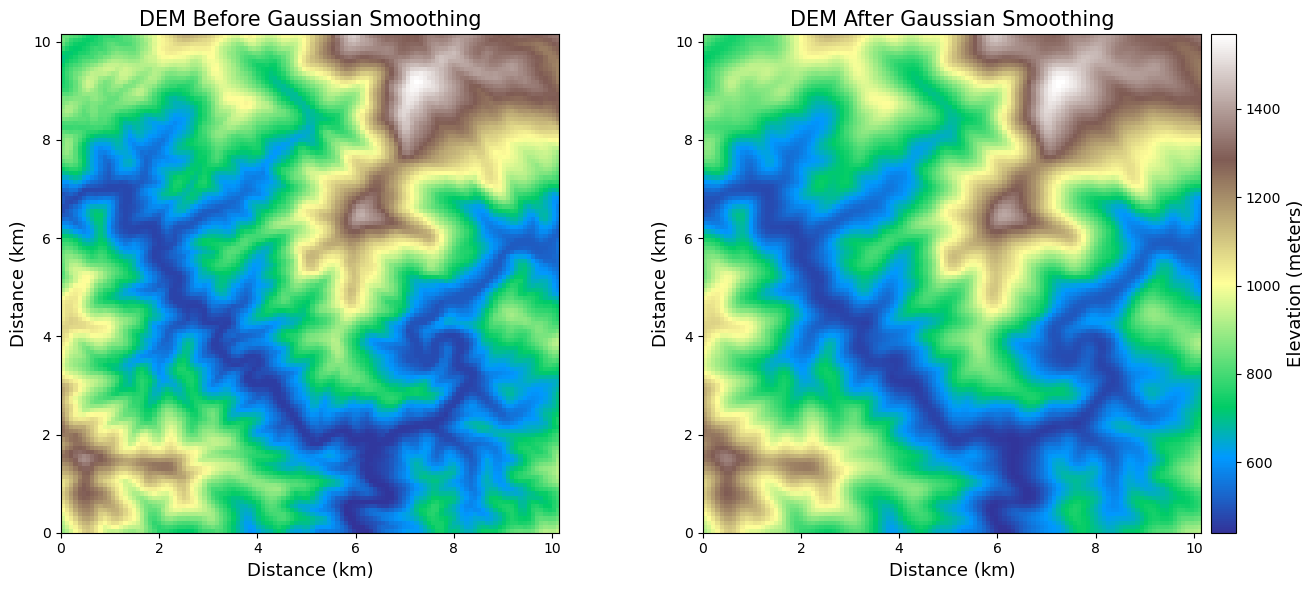

In [129]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

def extract_area_of_interest(dem, lat, lon, width, height, transform):
    """Extracts a specific area of interest from the DEM based on latitude and longitude."""
    # Calculate the pixel coordinates of the given latitude and longitude
    col, row = ~transform * (lon, lat)

    # Convert to integers
    col = int(col)
    row = int(row)

    # Extract the region of interest (ROI)
    roi = dem[max(0, row-height//2):row+height//2, max(0, col-width//2):col+width//2]

    return roi

def plot_dem_before_after_filter(dem_path, lat, lon, sigma, width=2000, height=2000):
    # Read the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        nodata = src.nodata

    # Extract a larger area around the given latitude and longitude
    dem_sample = extract_area_of_interest(dem, lat, lon, width, height, transform)

    # Smooth the DEM using a Gaussian filter
    smoothed_dem_sample = gaussian_filter(dem_sample, sigma=sigma)

    # Convert pixel distances to kilometers for the scale
    pixel_size_m = 90  # Approximate at the equator (in meters)
    latitude_correction = np.cos(np.radians(lat))  # Correct for latitude
    x_km = np.linspace(0, width * pixel_size_m * latitude_correction / 1000, width)
    y_km = np.linspace(0, height * pixel_size_m * latitude_correction / 1000, height)

    # # Plot the original and smoothed DEM maps
    # plt.figure(figsize=(12, 6))

    # plt.subplot(1, 2, 1)
    # plt.title("DEM Before Gaussian Smoothing")
    # plt.imshow(dem_sample, cmap='terrain', extent=[x_km[0], x_km[-1], y_km[-1], y_km[0]])
    # plt.colorbar(label='Elevation (meters)')
    # plt.xlabel('Distance (km)')
    # plt.ylabel('Distance (km)')

    # plt.subplot(1, 2, 2)
    # plt.title("DEM After Gaussian Smoothing")
    # plt.imshow(smoothed_dem_sample, cmap='terrain', extent=[x_km[0], x_km[-1], y_km[-1], y_km[0]])
    # plt.colorbar(label='Elevation (meters)')
    # plt.xlabel('Distance (km)')
    # plt.ylabel('Distance (km)')

    # plt.tight_layout()
    # plt.show()
    
    
    font_a = 15 
    font_b = 13
    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [0.933, 1]})

    # Plot the original DEM
    im1 = ax1.imshow(dem_sample, cmap='terrain', extent=[x_km[0], x_km[-1], y_km[0], y_km[-1]])
    ax1.set_title("DEM Before Gaussian Smoothing", fontsize=font_a)
    ax1.set_xlabel('Distance (km)', fontsize=font_b)
    ax1.set_ylabel('Distance (km)', fontsize=font_b)

    # Plot the smoothed DEM
    im2 = ax2.imshow(smoothed_dem_sample, cmap='terrain', extent=[x_km[0], x_km[-1], y_km[0], y_km[-1]])
    ax2.set_title("DEM After Gaussian Smoothing", fontsize=font_a)
    ax2.set_xlabel('Distance (km)', fontsize=font_b)
    ax2.set_ylabel('Distance (km)', fontsize=font_b)

    # Create a single colorbar for both plots
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax)
    cbar.set_label('Elevation (meters)', fontsize=font_b)

    plt.tight_layout()
    plt.show()


# Example usage
plot_dem_before_after_filter(
    'Raw_Spatial_Data/dem_laos.tif', 
    lat=20,  # Latitude for selected sample area
    lon=103.8610,  # Longitude for selected sample area
    sigma=1,  # Sigma value for Gaussian smoothing
    width=120,  # Width of the sample area in pixels
    height=120  # Height of the sample area in pixels
)
